In [1]:
#Numpy
import numpy as np
#Pickle
import pickle
#OpenCV
import cv2
#OS
from os import listdir
#Keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
#Sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#Matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Set the number of Epochs
EPOCHS = 25

#Learning Rate
INIT_LR = 1e-3

#Batch size
#Usually taken as 32, 64, 128 etc
#The overall idea is to fit your batch entirely in the the CPU/GPU. 
#Since, all the CPU/GPU comes with a storage capacity in power of two, it is advised to keep mini-batch size a power of two.
BS = 32

# Set default image size
default_image_size = tuple((256, 256))
image_size = 0

#Set the root directory
directory_root = '../input/plantdisease/'

#Also set the width, height and depth
width=256
height=256
depth=3

In [3]:
#Have a function to convert the image to array as it will be easy to work with
def convert_image_to_array(image_dir):
    try:
        #Read the image using OpenCV
        image = cv2.imread(image_dir)
        if image is not None :
            #If image exists, resize image to default image size and convert it to array
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            # When there is no image, return an empty image
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
#Create an empty image list and label list
image_list, label_list = [], []
#Here, the images are accessed, converted to array format and stored 
#A list of their labels are also stored
#Unwanted Images or NULL Errors are removed from data
#Clean the given dataset
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for plant_disease in plant_disease_folder_list :
            # remove .DS_Store from list
            #Clean Data
            #Remove data which is not necessary
            if plant_disease=="Potato___Late_blight" or plant_disease=="Potato___healthy" or plant_disease=="Pepper__bell___Bacterial_spot" or plant_disease=="Potato___Early_blight" or plant_disease=="Pepper__bell___healthy":
                    plant_disease_folder_list.remove(plant_disease)
            if plant_disease == ".DS_Store" :
                plant_disease_folder_list.remove(plant_disease)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    #Convert the Image to array for further analysis
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing PlantVillage ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Image loading completed


In [5]:
#Get the image size, which was initially set to zero
image_size = len(image_list)

In [6]:
#One hot encoding
#Conversion to Vector
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#Storing it in file
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
#Getting the length of the label classes 
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Tomato_Bacterial_spot'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_Leaf_Mold'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites_Two_spotted_spider_mite'
 'Tomato__Target_Spot' 'Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Tomato__Tomato_mosaic_virus' 'Tomato_healthy']


In [8]:
#normalizing the given data
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
#Splitting data into train and test data with test_size=0.2 and random state=42
#random_state is basically used for reproducing your problem the same every time it is run.
#If you do not use a random_state in train_test_split, every time you make the split you might 
#get a different set of train and test data points and will not help you in debugging in case you get an issue.
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
#Make variations to the image so that the model does not get confused
#Rotate it by 90
#Model will consider all these as same meaning it won't consider inverted,filled image as different but takes only common features
#from those 
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
#CNN Model
#Creates a linear stack of arrays
#Simplest type of Model
model = Sequential()

#height, width and depth as defined above
inputShape = (height, width, depth)
chanDim = -1

#If channels first change the order as required
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
#CNN Model
#Creates a linear stack of arrays
#Simplest type of Model
model = Sequential()

#height, width and depth as defined above
inputShape = (height, width, depth)
chanDim = -1

#If channels first change the order as required
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

#Adding layers
#Convolution layer with same padding
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Add max pooling layer with 3*3 filter which reduces the size 
model.add(MaxPooling2D(pool_size=(3, 3)))
#Also add a dropout layer
model.add(Dropout(0.25))
#Convolution layer with same padding
model.add(Conv2D(64, (3, 3), padding="same",input_shape=inputShape))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Convolution layer with same padding
model.add(Conv2D(64, (3, 3), padding="same",input_shape=inputShape))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Add max pooling layer with 3*3 filter which reduces the size 
model.add(MaxPooling2D(pool_size=(2,2)))
#Also add a dropout layer
model.add(Dropout(0.25))
#Convolution layer with same padding
model.add(Conv2D(128, (3, 3), padding="same",input_shape=inputShape))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Convolution layer with same padding
model.add(Conv2D(128, (3, 3), padding="same",input_shape=inputShape))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Add max pooling layer with 3*3 filter which reduces the size 
model.add(MaxPooling2D(pool_size=(2,2)))
#Also add a dropout layer
model.add(Dropout(0.25))
#Flatten it or condense it
model.add(Flatten())
#Add dense layer
model.add(Dense(1024))
#ReLU Activation Function
model.add(Activation("relu"))
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization(axis=chanDim))
#Also add a dropout layer
model.add(Dropout(0.5))
#Add dense layer
model.add(Dense(n_classes))
#Finally use a softmax layer
model.add(Activation("softmax"))

In [ ]:
#Displaying the summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [ ]:
#Optimization
#Learning Rate and Epochs is defined above
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
#Training it
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
55/55 [==============================] - 36s 654ms/step - loss: 0.2606 - acc: 0.9149 - val_loss: 0.4969 - val_acc: 0.8981
Epoch 2/25
55/55 [==============================] - 25s 451ms/step - loss: 0.2215 - acc: 0.9251 - val_loss: 1.4689 - val_acc: 0.8651
Epoch 3/25
55/55 [==============================] - 25s 454ms/step - loss: 0.1744 - acc: 0.9404 - val_loss: 1.2640 - val_acc: 0.8698
Epoch 4/25
55/55 [==============================] - 26s 471ms/step - loss: 0.1472 - acc: 0.9475 - val_loss: 1.2899 - val_acc: 0.8717
Epoch 5/25
55/55 [==============================] - 25s 457ms/step - loss: 0.1319 - acc: 0.9521 - val_loss: 0.6819 - val_acc: 0.9128
Epoch 6/25
55/55 [==============================] - 25s 463ms/step - loss: 0.1333 - acc: 0.9491 - val_loss: 0.6748 - val_acc: 0.8942
Epoch 7/25
55/55 [==============================] - 25s 446ms/step - loss: 0.1230 - acc: 0.9553 - val_loss: 0.4700 - val_acc: 0.9147
Epoch 8/25
55/55 [==============================] - 26s 468ms/step - 

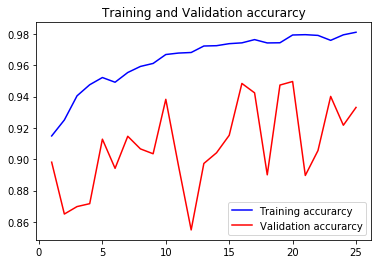

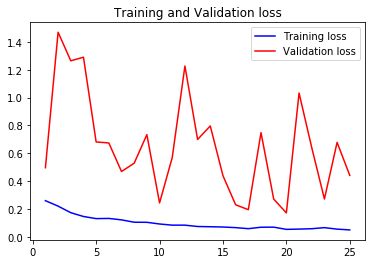

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
440/440 [==============================] - 1s 3ms/step
Test Accuracy: 93.30578446388245


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
model.save('cnn.h5')

In [ ]:
from flask import Flask

UPLOAD_FOLDER = '../input/folder/'

app = Flask(__name__)
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024

In [ ]:
import cv2
import tensorflow as tf
CATEGORIES=['None' 'Tomato_Bacterial_spot'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_Leaf_Mold'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites_Two_spotted_spider_mite'
 'Tomato__Target_Spot' 'Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Tomato__Tomato_mosaic_virus' 'Tomato_healthy']

def loop(filepath):
    img_array=cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    return img_array

def model_predict(img_path, model):
    img = image.load_img(img_path, grayscale=False, target_size=(64, 64))
    show_img = image.load_img(img_path, grayscale=False, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = np.array(x, 'float32')
    x /= 255
    preds = model.predict(x)
    return preds



In [ ]:
import os
import urllib.request
from flask import Flask, flash, request, redirect, url_for, render_template
from werkzeug.utils import secure_filename

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):
	return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS
	
@app.route('/')
def upload_form():
	return render_template('index.html')

@app.route('/', methods=['POST'])
def upload_image():
	if 'file' not in request.files:
		flash('No file part')
		return redirect(request.url)
	file = request.files['file']
	if file.filename == '':
		flash('No image selected for uploading')
		return redirect(request.url)
	if file and allowed_file(file.filename):
		filename = secure_filename(file.filename)
		file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
		#print('upload_image filename: ' + filename)
		model=tf.keras.models.load_model('./cnn.h5')
		pred=model.predict(model_predict(filename,model))
		pep=CATEGORIES[int(pred[0][0])]       
		return render_template('index.html', filename=filename,pep=pep)
	else:
		flash('Allowed image types are -> png, jpg, jpeg, gif')
		return redirect(request.url)

@app.route('/display/<filename>')
def display_image(filename):
	#print('display_image filename: ' + filename)
	return redirect(url_for('static', filename='uploads/' + filename), code=301)

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
